# Example Autopicker
Brendan Smithyman | March, 2016

## Imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
sys.path.append('/home/smithyman/Projects/zephyr/')

from pygeo.segyread import SEGYFile
from pygeo.analysis import energyratio
from zephyr.middleware import FullwvDatastore

%matplotlib inline
matplotlib.rcParams['savefig.dpi'] = 300

## Parameters

In [2]:
# Set parameters
projnm = 'toyani'   # Project name
windowLength = 5    # How long a window to use
pickOffset = -5     # How far back to shift picks from peak STA/LTA
zeroStart = 50      # How far back to blank in the first pass
zeroRel = -10       # How far back from the initial pick to blank in the second pass
unit = 1e3          # 1000 ms / s

outputFormat = '%(index)8d %(tag)4d %(sx)0.6e %(sz)0.6e %(rx)0.6e %(rz)0.6e %(pick)e\n'
banner = 'Picks output for %s by simplepicker\nhttps://github.com/uwoseis/simplepicker/\n\n'%(projnm,)

## Computation

In [3]:
fds = FullwvDatastore(projnm)
systemConfig = fds.systemConfig
infile = '%s.ppre'%(projnm,)
outfile = '%s.picks'%(projnm,)
nsrc = fds.ini['ns']
nrec = fds.ini['nr']

sf = SEGYFile(infile)
data = sf[:]
er = energyratio(data, windowLength)
er0 = er.copy()
er0[:,:zeroStart] = 0
picks = np.argmax(er0, axis=1) + pickOffset
del(er0)
er1 = er.copy()
for itrace in xrange(sf.ntr):
    er1[itrace,:picks[itrace]+zeroRel] = 0
picks = np.argmax(er1, axis=1) + pickOffset
del(er1)

clipScale = 0.5*abs(data).max()
def getInfo(isrc):
    trStart = isrc * nrec
    trEnd   = trStart + nrec
    return data[trStart:trEnd], er[trStart:trEnd], picks[trStart:trEnd]

## Review

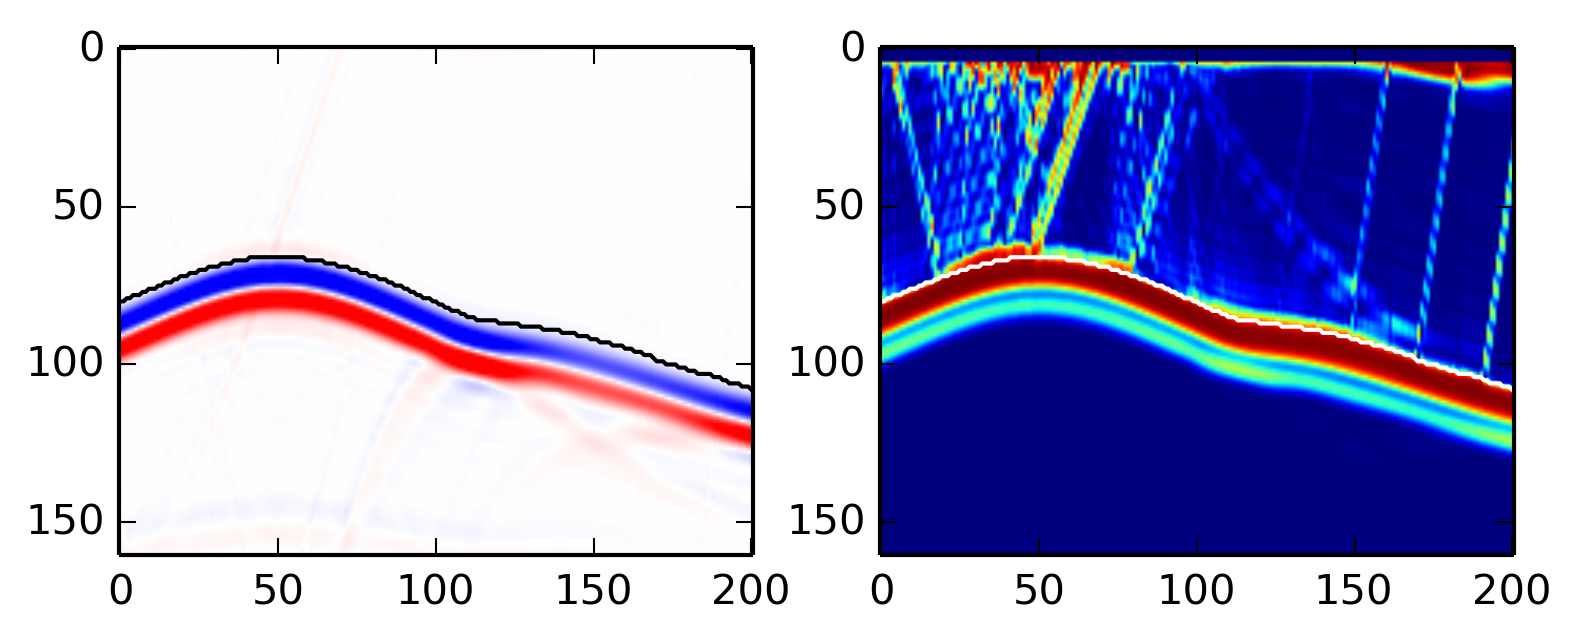

In [4]:
shotGather = 50

dataGather, erGather, picksGather = getInfo(shotGather)

fig = plt.figure()
plt.subplot(1,2,1)
plotOpts = {
    'vmin': -clipScale,
    'vmax': clipScale,
    'cmap': cm.bwr,
}
plt.imshow(dataGather.T, **plotOpts)
axis0 = plt.axis()
plt.plot(picksGather, 'k-')
plt.axis(axis0)

plt.subplot(1,2,2)
plotOpts = {
    'cmap': cm.jet,
}
plt.imshow(erGather.T, **plotOpts)
plt.plot(picksGather, 'w-')
axis0 = plt.axis(axis0)

## Output

In [5]:
timePicks = unit * picks * sf.bhead['hdt']

sx, sz, sw = fds.ini['srcs'].T
rx, rz, rw = fds.ini['recs'].T

with open(outfile, 'w') as fp:
    fp.write(banner)
    fp.write('%d\n%d\n'%(len(timePicks),7))
    for isrc in xrange(nsrc):
        for irec in xrange(nrec):
            index = isrc*nrec + irec
            data = {
                'index':    index + 1,
                'tag':      0,
                'sx':       sx[isrc],
                'sz':       sz[isrc],
                'rx':       rx[irec],
                'rz':       rz[irec],
                'pick':     timePicks[index],
            }
            line = outputFormat%data
            fp.write(line)